# Meshed AC-DC Networks

This example demonstrates how to optimize meshed AC_DC networks in PyPSA. The example has a 3-node AC network coupled via AC-DC converters to a 3-node DC network. There is also a single point-to-point DC connection using the ```Link``` component.

#### What kind of problem is this?
Capacity expansion + optimal power flow problem on a meshed hybrid AC–DC network. This is linear optimal power flow **(LOPF)** with :
* AC subnetworks (linearized DC load flow approximation)
* DC subnetworks (pure transport model)
* AC-DC converters (modelled as controllable links)
* Extendable generation and line capacities
* Multiple time steps (10 hrs)

**Multi-period linear optimal power flow with investment**

It is a large linear program (LP), not MILP, no unit commitment here.

#### Network structure:
From ```n.determine_network_topology()```

We get 4 subnetworks:
1. Subnetwork 0 : Type - AC, Meaning - UK AC mesh
2. Subnetwork 1 : Type - DC, Meaning - DC grid
3. Subnetwork 2 : Type - AC, Meaning - Continental AC 
4. Subnetwork 3 : Type - AC, Meaning - Norway single bus

Important to note:
* AC networks obey Kirchhoff's Voltage Law (KVL)
* DC networks behave like transport networks (no phase angles)
* Converters are modelled as Links

#### Mathematical Formulation:
**Sets:**
* $n \in \mathcal{N}:$ buses
* $l \in \mathcal{L}:$ AC lines
* $k \in \mathcal{K}:$ links (converters + DC link)
* $g \in \mathcal{G}:$ generators
* $t \in \mathcal{T}:$ time snapshots

**Decision Variables:**
For each time $t$:

Generation: $p_{g,t}$

Line flows: $f_{l,t}$

Link flows: $f_{f,t}$

Voltage angles (AC only): $\theta_{n,t}$

Investment variables: $p_g^{nom, opt}$, $s_l^{nom, opt}$

#### Objective Function:

This is inverstment + operational cost:
$$\min \sum_g C_g^{cap} p_g^{nom,opt} + \sum_l C_l^{cap} s_l^{nom,opt} + \sum_t\sum_g c_g p_{g,t}$$
Where:
* $C^{cap}-$ capital cost
* $c_g=$ marginal cost

#### Operational Constraints:
(A) Generator limits: $0\leq p_{g,t} \leq p_g^{nom,opt} \cdot p_{g,t}^{max_pu}$

Wind has time-varying $p^{max_pu}$. Gas has cosntant availability.

(B) Power Balance at Every Bus: FOr every bus $n$:
$$\sum_{g\in n} p_{g,t} + \sum_{k\in n} f_{k,t} + \sum_{l\in n} f_{l,t} = d_{n,t} $$
That gives the locational marginal price (LMP) as the dual variable.

(C) AD Line Flow Equations (Linearized DC Load Flow)

For AC lines: $$f_{l,t} = \frac{1}{x_l} (\theta_{i,t} - \theta_{j,t}) $$
Where:
* $x_l= $ reactance
* $i,j = connected buses

This enforces Kirchhoff's Voltage Law.

(D) Line Capacity Constraints: $|f_{l,t}| \leq s_l^{nom,opt}$

(E) Link Constraints (Converters + DC link)

For links: $$-p_k^{nom,opt} \leq f_{k,t} \leq p_k^{nom,opt}$$
Converters simply move power between AC and DC buses.

#### Conceptual Difference from Unit Commitment

|**Unit Commitment** | **This Example**|
|---|---|
| MILP | LP|
| Binary on/off | Continuous |
|Start-up costs | No |
| Ramping | No |
| Investment | Yes |

This is long-term planning, not operational scheduling. Think of it as “What generation and transmission capacities should Europe build, and how should it dispatch them over 10 hours, if AC and DC grids are interconnected?”

In [16]:
import pypsa

n = pypsa. examples.ac_dc_meshed()
n.links.loc["Norwich Converter", "p_nom_extendable"] = False

INFO:pypsa.network.io:Imported network 'AC-DC-Meshed' has buses, carriers, generators, global_constraints, lines, links, loads


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x70d6f81afd40>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x70d6f81dcce0>,
  'Line': <matplotlib.collections.LineCollection at 0x70d70015a720>},
 'flows': {}}

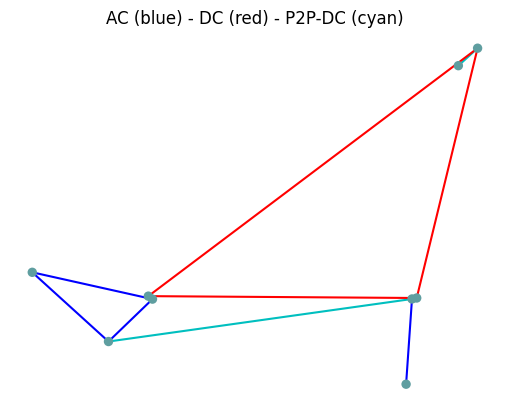

In [17]:
line_color = n.lines.bus0.map(n.buses.carrier).map(
    lambda ct: "r" if ct == "DC" else "b")

n.plot(
    line_color=line_color,
    link_color="c",
    title="AC (blue) - DC (red) - P2P-DC (cyan)",
    jitter=0.4,
)

We inspect the topology of the network. Therefore, use ```n.determine_network_topology()``` and inspect the subnetworks in ```n.sub_networks()```

In [18]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [len(sn.branches()) for sn in n.sub_networks.obj]
n.sub_networks["n_buses"] = [
    len(sn.components.buses.static) for sn in n.sub_networks.obj
]
n.sub_networks

,carrier,slack_bus,obj,n_branches,n_buses
name,,,,,
0,AC,Manchester,<pypsa.networks.SubNetwork object at 0x70d6f81...,3,3
1,DC,Norwich DC,<pypsa.networks.SubNetwork object at 0x70d7001...,3,3
2,AC,Frankfurt,<pypsa.networks.SubNetwork object at 0x70d6f9f...,1,2
3,AC,Norway,<pypsa.networks.SubNetwork object at 0x70d6f9f...,0,1


The network covers 10 time steps. These are given by the ```snapshots``` attribute.

In [19]:
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

There are 6 generators in the network, 3 wind and 3 gas. All are attached to AC buses:

In [20]:
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
Manchester Wind,Manchester,Slack,,80.0,0.0,True,100.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Manchester Gas,Manchester,PQ,,50000.0,0.0,True,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Norway Wind,Norway,Slack,,100.0,0.0,True,100.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Norway Gas,Norway,PQ,,20000.0,0.0,True,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Frankfurt Wind,Frankfurt,Slack,,110.0,0.0,True,100.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Frankfurt Gas,Frankfurt,PQ,,80000.0,0.0,True,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


We see that the generators have different capital and marginal costs. All of them have a ```p_nom_extendable``` set to ```True```, meaning that capacities can be extended in the optimisation. The wind generators have a per unit limit for each time step, given by the weather potentials at the site.

<Axes: xlabel='snapshot'>

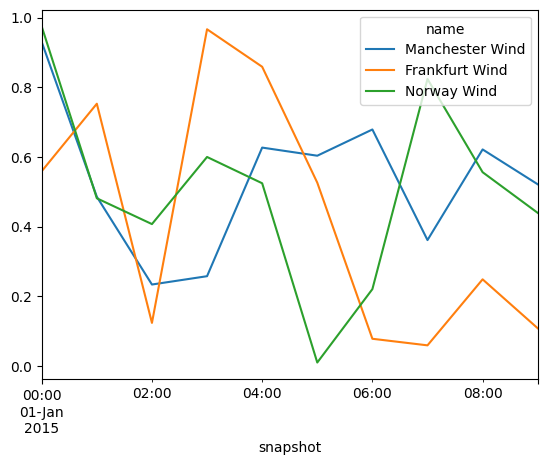

In [21]:
n.generators_t.p_max_pu.plot()

Now we know how the network looks like, where the generators and lines are. Let's perform a optimization of the operation and capacities.

In [22]:
n.optimize();

Index(['2', '3', '4'], dtype='object', name='name')
Index(['0', '1', '5', '6'], dtype='object', name='name')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 187 primals, 467 duals
Objective: -3.47e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-fhkinf39 has 467 rows; 187 cols; 986 nonzeros
Coefficient ranges:
  Matrix  [1e-02, 1e+00]
  Cost    [9e-03, 3e+03]
  Bound   [2e+07, 2e+07]
  RHS     [9e-01, 1e+03]
Presolving model
371 rows, 186 cols, 890 nonzeros  0s
283 rows, 98 cols, 948 nonzeros  0s
Dependent equations search running on 22 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
283 rows, 98 cols, 948 nonzeros  0s
Presolve reductions: rows 283(-184); columns 98(-89); nonzeros 948(-38) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.1204315428e+07 Pr: 110(100734); Du: 0(1.34157e-11) 0s
        104    -3.4740941308e+06 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-fhkinf

The objective is given by:

In [23]:
n.objective

-3474094.130816234

#### Why is the Objective Negative?

It considers the starting point of the optimization, thus the existent capacities given by ```n.generators.p_nom``` are taken into account.

PyPSA includes an objective constant where the constant represents cost of existing capacities, and baseline investment. The solver only optimizes the variable part.

The real system cost are given by ```n.objective + n.objective_constant```

In [24]:
n.objective + n.objective_constant

18440973.38746291

The optimal capcities are given by ```p_nom_opt``` for generators, links and storage and ```s_nom_opt``` for lines.

Let's look how the optimal capacities for generators look like.

In [25]:
n.generators.p_nom_opt.div(1e3).round(2).sort_values()

name
Manchester Gas    -0.00
Norway Gas        -0.00
Frankfurt Gas      0.98
Norway Wind        1.53
Frankfurt Wind     1.67
Manchester Wind    4.09
Name: p_nom_opt, dtype: float64

#### Why does only Wind Expand?

Wind if los marginal cost and higher capital cost, while Gas is high marginal cost. Since demand spans 10 hours, the model finds Wind CAPEX < Gas OPEX over 10 hours. So it builds wind adn minimizes gas usage. This is a classic merit-order + investment equilibrium.

Their production is again given as a time-seris in ```n.generators_t```.

<Axes: xlabel='snapshot', ylabel='Power [GW]'>

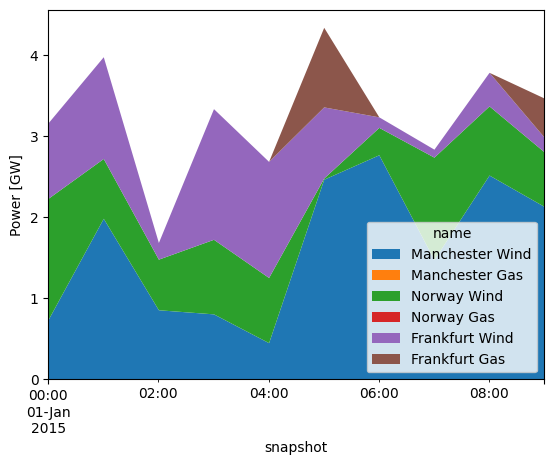

In [26]:
n.generators_t.p.div(1e3).plot.area(stacked=True, lw=0, ylabel="Power [GW]" )

#### Locational Marginal Prices:

From the optimization these are given for each bus and snapshot. LMP at bus $n$, time $t$ is:
$$\lambda_{n,t} = \frac{\delta System Cost}{\delta d_{n,t}} $$
It equals:
* Marginal generator cost
* Plus congestion cost
* Plus losses (if modeled)

Since AC grid is meshed:
* If no congestion $\rightarrow$ prices equalize
* If congestion $\rightarrow$ prices differ

The plot shows time varying prices due to:
* Wind availability
* Congestion
* Converter limits

<Axes: xlabel='snapshot', ylabel='Marginal Price [€/MWh]'>

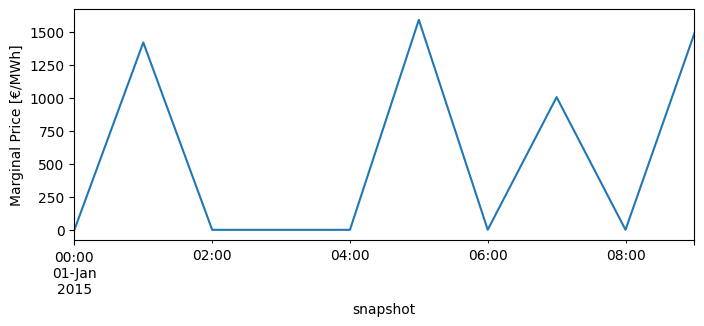

In [27]:
n.buses_t.marginal_price.mean(axis=1).plot(figsize=(8,3), ylabel="Marginal Price [€/MWh]")

We can inspect further quantities as the active power of AC-DC converters and HVDC link.

#### What are the AC-DC Converters Doing?
From ```n.links_t.p0```

Positive flow means power flowing from bus to bus1.

Converters:
* Transfer cheap wind between AC and DC regions
* Equalize marginal prices across AC/DC boundary
* Limited by capacity

If converter congests: AC and DC prices separate

In [28]:
n.links_t.p0.round(2)

name,Norwich Converter,Norway Converter,Bremen Converter,DC link
snapshot,,,,
2015-01-01 00:00:00,-250.84,674.58,-423.74,-318.00
2015-01-01 01:00:00,315.07,-116.73,-198.34,-318.00
2015-01-01 02:00:00,350.76,581.97,-932.73,-318.00
2015-01-01 03:00:00,-85.77,272.56,-186.79,-318.00
2015-01-01 04:00:00,317.37,-79.75,-237.62,-318.00
2015-01-01 05:00:00,386.75,-494.20,107.45,-318.00
2015-01-01 06:00:00,900.00,-257.52,-642.48,318.00
2015-01-01 07:00:00,123.68,971.92,-1095.60,-86.86
2015-01-01 08:00:00,244.72,850.88,-1095.60,318.00


In [29]:
n.lines_t.p0.round(2)

name,0,1,2,3,4,5,6
snapshot,,,,,,,
2015-01-01 00:00:00,79.47,-38.11,-52.97,-303.81,370.78,-202.73,-534.34
2015-01-01 01:00:00,-449.46,787.04,-211.27,103.80,-12.93,209.36,-823.21
2015-01-01 02:00:00,-181.27,520.56,-505.91,-155.15,426.82,-248.68,173.90
2015-01-01 03:00:00,-45.47,234.47,-34.04,-119.81,152.75,-232.72,-743.79
2015-01-01 04:00:00,-73.21,295.42,-227.20,90.17,10.42,-240.11,-883.82
2015-01-01 05:00:00,-594.50,1198.08,-125.90,260.84,-233.35,19.36,-1030.85
2015-01-01 06:00:00,-661.29,1378.42,-632.37,267.63,10.11,-53.45,319.39
2015-01-01 07:00:00,-383.77,540.91,-469.93,-346.25,625.67,393.72,600.73
2015-01-01 08:00:00,-778.28,1444.07,-522.12,-277.40,573.48,229.29,501.35


In [30]:
n.buses_t.p.round(2)

name,London,Norwich,Norwich DC,Manchester,Bremen,Bremen DC,Frankfurt,Norway,Norway DC
snapshot,,,,,,,,,
2015-01-01 00:00:00,282.20,-164.62,-250.84,-117.58,-534.34,-423.74,534.34,0.0,674.58
2015-01-01 01:00:00,-658.83,-577.67,315.07,1236.50,-823.21,-198.34,823.21,0.0,-116.73
2015-01-01 02:00:00,67.41,-769.24,350.76,701.83,173.90,-932.73,-173.90,0.0,581.97
2015-01-01 03:00:00,187.24,-467.19,-85.77,279.94,-743.79,-186.79,743.79,0.0,272.56
2015-01-01 04:00:00,166.90,-535.53,317.37,368.63,-883.82,-237.62,883.82,0.0,-79.75
2015-01-01 05:00:00,-613.86,-1178.72,386.75,1792.58,-1030.85,107.45,1030.85,0.0,-494.20
2015-01-01 06:00:00,-607.85,-1431.87,900.00,2039.72,319.39,-642.48,-319.39,0.0,-257.52
2015-01-01 07:00:00,-777.48,-147.19,123.68,924.68,600.73,-1095.60,-600.73,0.0,971.92
2015-01-01 08:00:00,-1007.58,-1214.77,244.72,2222.35,501.35,-1095.60,-501.35,0.0,850.88
